In [1]:
import tensorflow as tf 
tf.test.gpu_device_name()

''

In [2]:
from google.colab import files
upload = files.upload()

Saving 3-class.csv to 3-class.csv


In [3]:
up_list = files.upload()

Saving list.txt to list.txt


In [4]:
!mkdir outputs
!pip3 install keras_metrics

In [0]:
# -*- coding: utf-8 -*-
#-------------------------------------------------------------------------------

import itertools
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


import re
from keras import regularizers
import sys
import codecs
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
#from nltk.stem.arlstem import ARLSTem
import gensim
from gensim.models.word2vec import Word2Vec


import keras
from keras import layers
from keras import optimizers

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import to_categorical
import keras_metrics
from keras.layers import Embedding
from sklearn.model_selection import train_test_split

from keras.engine.topology import Layer

In [5]:
from keras.utils import get_file
cbow = get_file('cbow_100.zip', 'https://archive.org/download/aravec2.0/tweet_cbow_100.zip', extract=True)
cbow

Using TensorFlow backend.


253952000/253946430 [==============================] - 15s 0us/step


'/root/.keras/datasets/cbow_100.zip'

In [8]:
!ls /root/.keras/datasets/

cbow_100.zip	 tweets_cbow_100.trainables.syn1neg.npy
tweets_cbow_100  tweets_cbow_100.wv.vectors.npy


In [0]:
from pathlib import Path
cbow_path = Path('/root/.keras/datasets/tweets_cbow_100')

In [10]:
import keras.backend as K
K.clear_session()

In [11]:
data = pd.read_csv('3-class.csv', encoding='utf-8')
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head()

(56674, 2)


,Tweet,Polarity
0,عبدالعزيز الهدلق ل المنتصف السواد الاعظم من ج...,neut
1,نواف بن سعد في طريقه ل القصيم لحضور مباراه ال...,neut
2,مافيه اجمل من فوز الهلال الا صياح النصراوي ال...,pos
3,نجم اللقاا نادي الهلال السعودي,pos
4,الفرج لازم يحاسب اما انه يلعب مثل مايلعب زملا...,neg


In [12]:
data.sample(frac=1)

,Tweet,Polarity
53870,الميزانيه_السعوديه هام رفع الدعم عن المنتجات ...,neut
34751,الدووورررييي مووولععع الهلال_هجر النصر_الاتحاد...,pos
27655,الدكتور عمر_القويري يحذر اوروبا قبل اشهر من هج...,neut
23892,اللحين الهلال متصدر حتى ولو فاز الاهلي,pos
40539,ص ح خميسكم فله ايها الموظفين الكادحين طوال الا...,pos
...,...,...
51378,لا ادري لما استوقفتني هذه الصوره فيها من الال...,pos
38919,على زق ي جاريه عبدالملك الحوثي ي قني,neg
17134,شادي ابو هشهش نطق بما احرق جوفه وحرمه السكوت ...,neg
56258,الي طلع من كاس ولي العهد يقصر حسه الهلال_التعاون,neg


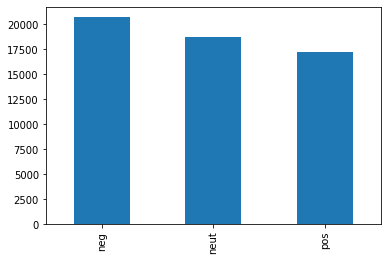

In [13]:
data['Polarity'].value_counts().sort_index().plot.bar()

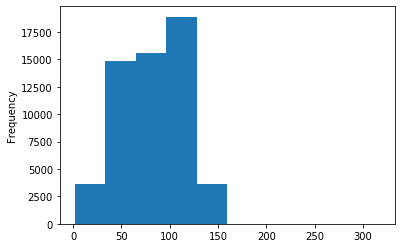

In [14]:
data['Tweet'].str.len().plot.hist()

In [15]:
def transform(x):
    if x == 'neg':
        return 0
    elif x == 'pos':
        return 1
    return 2
data['Sentiment'] = data['Polarity'].apply(transform)
data.head()

,Tweet,Polarity,Sentiment
0,عبدالعزيز الهدلق ل المنتصف السواد الاعظم من ج...,neut,2
1,نواف بن سعد في طريقه ل القصيم لحضور مباراه ال...,neut,2
2,مافيه اجمل من فوز الهلال الا صياح النصراوي ال...,pos,1
3,نجم اللقاا نادي الهلال السعودي,pos,1
4,الفرج لازم يحاسب اما انه يلعب مثل مايلعب زملا...,neg,0


In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
#remove users
data['clean'] = data['Tweet'].apply(lambda x: re.sub('(@[A-Za-z]+)', '', x, flags=re.UNICODE))

#remove hashtags
#data['clean'] = data['clean'].apply(lambda x: re.sub('([أ-ي]+_[أ-ي]+)', '', x, flags=re.UNICODE))
#data['clean'] = data['clean'].apply(lambda x: re.sub('(_[أ-ي]+)', '', x, flags=re.UNICODE))
data['clean'] = data['clean'].apply(lambda x: re.sub('(_)', ' ', x, flags=re.UNICODE))
#remove letters, numbers & symbols
data['clean'] = data['clean'].apply(lambda x: re.sub('[a-zA-Z0-9@=$:.،%^*"#~£/&\n؟?!-_]', '', x, flags=re.UNICODE))

#arabic numbers
data['clean'] = data['clean'].apply(lambda x: re.sub('[٠١٢٣٤٥٦٧٨٩]', '', x, flags=re.UNICODE))

#nltk tokenize
data['clean'].apply(word_tokenize)
data['clean'] = data['clean'].apply(word_tokenize) 

#repeated letters
data['clean']= data['clean'].apply(lambda x: [''.join(ch for ch, _ in itertools.groupby(y)) for y in x])

#normalization
def normalizeArabic(text):
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    return(text)
data['clean']= data['clean'].apply(lambda x: [normalizeArabic(y) for y in x])

#remove stopwords
def get_stop_words():
    path = 'list.txt'
    stop_words = []
    with codecs.open(path, "r", encoding="utf-8", errors="ignore") as myfile:
        stop_words = myfile.readlines()
    stop_words = [word.strip() for word in stop_words]
    return stop_words

stop_words = get_stop_words()
data['clean']= data['clean'].apply(lambda x: [item for item in x if item not in stop_words])

#remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data['clean']= data['clean'].apply(lambda x: [remove_emoji(y) for y in x])

data.head(10)

,Tweet,Polarity,Sentiment,clean
0,عبدالعزيز الهدلق ل المنتصف السواد الاعظم من ج...,neut,2,"[عبدالعزيز, الهدلق, المنتصف, السواد, الاعظم, ج..."
1,نواف بن سعد في طريقه ل القصيم لحضور مباراه ال...,neut,2,"[نواف, سعد, طريقه, القصيم, لحضور, مباراه, الهل..."
2,مافيه اجمل من فوز الهلال الا صياح النصراوي ال...,pos,1,"[مافيه, اجمل, فوز, الهلال, صياح, النصراوي, اله..."
3,نجم اللقاا نادي الهلال السعودي,pos,1,"[نجم, القا, نادي, الهلال, السعودي]"
4,الفرج لازم يحاسب اما انه يلعب مثل مايلعب زملا...,neg,0,"[الفرج, لازم, يحاسب, يلعب, مايلعب, زملاه, تري,..."
5,تعليق_الدراسه_في_القصيم مبروك يالنصراوين في ا...,pos,1,"[تعليق, الدراسه, القصيم, مبروك, يالنصراوين, ال..."
6,الهلال_الشباب انت الاول دايم و غيرك يهيم ي ال...,pos,1,"[الهلال, الشباب, انت, دايم, غيرك, يهيم, الزعيم]"
7,النصر_الاتحاد من نظره الرجال تعرف خوافيه الف ...,pos,1,"[النصر, الاتحاد, نظره, الرجال, تعرف, خوافيه, م..."
8,ولاننا زيكم بالضبط ليه انتم تعليق والرياض وجد...,neut,2,"[ولانا, زيكم, بالضبط, ليه, انتم, تعليق, والريا..."
9,هدف قاتل من الزوري في الوقت الضائع ينقذ الهلال...,pos,1,"[هدف, قاتل, الزوري, الضاءع, ينقذ, الهلال, مصيد..."


In [19]:
CBOW = Word2Vec.load(str(cbow_path))
CBOWE = CBOW.wv.get_keras_embedding()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
y = to_categorical(data['Sentiment'].values)

In [21]:
tokenizer = Tokenizer(num_words=len(data['clean']), split=" ")
tokenizer.fit_on_texts(data['clean'].values)

X = tokenizer.texts_to_sequences(data['clean'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,   144, 11265,  3619,  9986,  9987,   102,     1,
         1415,   184,   128,   250,     1,     2,    73,    55,    67],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   376,   340,   682,     9,  9988,    33,     1,    11],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   240,   123,   103,     1,   432,  1089,     1,    18],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,   494,   946,   120,     1,   104],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   109,   185,  3801,   177,  3620, 18660,
  

In [22]:
X.shape

(56674, 27)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
#Metrics
def plot_data(H, EPOCHS, name='figure.png'):
    # plot the losses
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, EPOCHS), H['acc'],
        label="Accuracy")
    plt.plot(np.arange(0, EPOCHS), H['val_acc'],
        label="Val_Accuracy")
    plt.plot(np.arange(0, EPOCHS), H['loss'],
        label="Loss")
    plt.plot(np.arange(0, EPOCHS), H['val_loss'],
        label="Val_Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy & Loss")
    plt.legend(loc="upper right")
    plt.show()
    if name:
        plt.savefig(name)

In [0]:
#calculation
from keras import backend as K


# calculate f score
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
# metrics all
metrics = [
    'accuracy',
    keras_metrics.precision(),
    keras_metrics.recall(),
    f1,
]

In [0]:
# hyperparamters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2
EPOCHS = 20

In [0]:
#build model
def buildAndRunModel(model, ckpt_path):
    # callbacks
    checkpoints = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, save_weights_only=False)
    
    model.compile(loss='categorical_crossentropy', 
                   optimizer='adam',
                   metrics=metrics,)
    H = model.fit(X_train, y_train, 
               validation_split=VALIDATION_SPLIT, 
               batch_size=BATCH_SIZE, 
               epochs=EPOCHS,
               callbacks=[checkpoints],)
    return H

In [0]:
def eval_model(model):
    E = model.evaluate(X_test, y_test)
    return list(zip(E, model.metrics_names))

In [30]:
#GRU

gru_model_input = layers.Input(shape=(X_train.shape[1],))
x = CBOWE(gru_model_input)
x = layers.GRU(100, return_sequences=True, dropout=0.5)(x)

x = layers.Flatten()(x)
x = layers.Dense(100, activation='relu', name='desne1')(x)
x = layers.Dense(3, activation='softmax', name='desne_output')(x)

gru_model = keras.models.Model(inputs=gru_model_input, outputs=x)









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [31]:
gru_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 27)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 27, 100)           33167900  
_________________________________________________________________
gru_1 (GRU)                  (None, 27, 100)           60300     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2700)              0         
_________________________________________________________________
desne1 (Dense)               (None, 100)               270100    
_________________________________________________________________
desne_output (Dense)         (None, 3)                 303       
Total params: 33,498,603
Trainable params: 330,703
Non-trainable params: 33,167,900
_________________________________________

In [32]:
%%time
GRU_H = buildAndRunModel(gru_model, 'gru_ckpt')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 36271 samples, validate on 9068 samples
Epoch 1/20
36271/36271 [==============================] - 40s 1ms/step - loss: 1.0137 - acc: 0.4864 - precision: 0.5518 - recall: 0.2226 - f1: 0.3109 - val_loss: 0.8686 - val_acc: 0.6000 - val_precision: 0.6177 - val_recall: 0.5184 - val_f1: 0.5671
Epoch 2/20
36271/36271 [==============================] - 39s 1ms/step - loss: 0.8954 - acc: 0.5841 - precision: 0.6191 - recall: 0.4586 - f1: 0.5240 - val_loss: 0.8067 - val_acc: 0.6378 - val_precision: 0.6730 - val_recall: 0.5360 - val_f1: 0.6115
Epoch 3/20
36271/36271 [==============================] - 39s 1ms/step - loss: 0.8499 - acc: 0.6092 - precision: 0.6487 - recall: 0.5014 - f1: 0.5610 - val_loss: 0.7813 - val_acc: 0.6582 - val_precision: 0.6509 - val_recall: 0.6649 - val_f1: 0.6377
Epoch 4/20
36271/36271 [==============================] - 39s 1ms/step - loss: 0.8312 - acc: 0.6216 - prec

In [33]:
eval_model(gru_model)

11335/11335 [==============================] - 3s 249us/step


[(0.7814594981951182, 'loss'),
 (0.674812527579992, 'acc'),
 (0.6719781470368319, 'precision'),
 (0.6963906581576695, 'recall'),
 (0.6601731325384274, 'f1')]

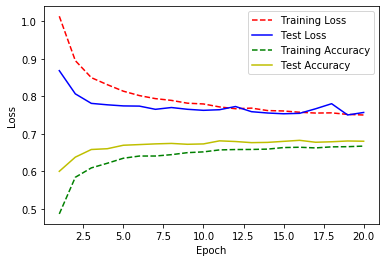

In [34]:
training_loss = GRU_H.history['loss']
test_loss = GRU_H.history['val_loss']
training_acc = GRU_H.history['acc']
test_acc = GRU_H.history['val_acc']
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.plot(epoch_count, training_acc, 'g--')
plt.plot(epoch_count, test_acc, 'y-')
plt.legend(['Training Loss', 'Test Loss', 'Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();